# Subsystem qutri code:
In this notebook we will work out the details of $Z_3$ honeycomb code
* defining lattice and parity check matrix
* decoders

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx
import sympy as sym

import pandas as pd
import os
import galois

Lets work out how to define lattice:

In [45]:
def torus(c: complex, distance: int) -> complex:
    """Apply toroidal topology to a point on the lattice."""
    r = c.real % (distance * 4)
    i = c.imag % (distance * 6)
    return r + i*1j

def sorted_complex(xs: Iterable[complex]) -> List[complex]:
    """Sort a list of complex numbers."""
    return sorted(xs, key=lambda v: (v.real, v.imag))

def int_to_pauli(i: int) -> str:
    """Convert an integer to a Pauli operator."""
    pauli_dict = {0: "X", 1: "Y", 2: "Z"}
    if i not in pauli_dict:
        raise ValueError('Integer must be 0, 1, or 2')
    return pauli_dict[i]

def initialize_hex_centers(distance: int) -> Dict[complex, int]:
    """Initialize the hex centers on the lattice."""
    hex_centers = {}
    for row in range(3 * distance):
        for col in range(2 * distance):
            center = row * 2j + 2 * col - 1j * (col % 2)
            category = (-row - col % 2) % 3
            hex_centers[torus(center, distance=distance)] = category
    return hex_centers

def categorize_hexes(hex_centers: Dict[complex, int]) -> Tuple[List[complex], List[complex], List[complex]]:
    """Categorize hexes into red, green, and blue."""
    red_hexes = [h for h, category in hex_centers.items() if category == 0]
    green_hexes = [h for h, category in hex_centers.items() if category == 1]
    blue_hexes = [h for h, category in hex_centers.items() if category == 2]
    return red_hexes, green_hexes, blue_hexes

def get_rgb_hexes(distance: int) -> Tuple[List[complex], List[complex], List[complex]]:
    """Get the red, green, and blue hexes."""
    hex_centers = initialize_hex_centers(distance=distance)
    red_hexes, green_hexes, blue_hexes = categorize_hexes(hex_centers=hex_centers)
    return red_hexes, green_hexes, blue_hexes


### lets define a qubit-plaquette dictionary:
def qubits_in_plaquettes(d):
    QUBITS_AROUND_HEX = [
        (-1 - 1j),
        (+1 - 1j),
        (+1),
        (+1 + 1j),
        (-1 + 1j),
        (-1)
    ]
    hexes = initialize_hex_centers(d)
    qubit_dictionary = {}
    for hex in hexes:
        qubit_coordinates = set()
        for qubit in QUBITS_AROUND_HEX:
            q = hex + qubit
            qubit_coordinates.add(torus(q,d))

        qubit_dictionary[hex] = qubit_coordinates

    return qubit_dictionary




In [46]:
d = 3
r_hex, g_hex, b_hex = get_rgb_hexes(d) 
qubits_for_plaq = qubits_in_plaquettes(d)

In [105]:
def neighbors(qubits1: set, qubits2: set):
    share_qubit = False
    if not qubits1.isdisjoint(qubits2):
        share_qubit=True
    return share_qubit



### Now lets define the graph

In [185]:
T = nx.Graph()

R_nodes,G_nodes,B_nodes = [[],[],[]]

for node, node_pos in enumerate(r_hex):
    T.add_node(node, pos=(node_pos.real, node_pos.imag, 0),color = 'red',xy = node_pos, label = '$p_{'+str(node)+'}$')
    R_nodes.append(node)
for node, node_pos in enumerate(g_hex):
    T.add_node(node + len(r_hex), pos=(node_pos.real, node_pos.imag, 1), color = 'green', xy = node_pos, label = '$p_{'+str(node)+'}$')
    G_nodes.append(node+len(r_hex))
for node, node_pos in enumerate(b_hex):
    T.add_node(node + len(r_hex)+len(g_hex), pos=(node_pos.real, node_pos.imag, 2), color = 'blue', xy = node_pos, label = '$p_{'+str(node)+'}$')
    B_nodes.append(node + len(r_hex)+len(g_hex))

#add data_nodes: 

data_counter = 0
data_nodes = []
for node_r in R_nodes:
    for node_b in B_nodes :
        xy_a, xy_b = [T.nodes[node_r]['xy'],T.nodes[node_b]['xy']]
        if neighbors(qubits_for_plaq[xy_a],qubits_for_plaq[xy_b]):
            data_counter+=1
            T.add_node(-data_counter, pos = (xy_a.real,xy_a.imag, 1.5), color = 'rb', xy = xy_a)
            data_nodes.append(-data_counter)

for node_g in G_nodes:
    for node_b in B_nodes :
        xy_a, xy_b = [T.nodes[node_g]['xy'],T.nodes[node_b]['xy']]
        if neighbors(qubits_for_plaq[xy_a],qubits_for_plaq[xy_b]):
            data_counter+=1
            T.add_node(-data_counter, pos = (xy_a.real,xy_a.imag, .5), color = 'gb', xy = xy_a)
            data_nodes.append(-data_counter)

#add edges

for data_node in data_nodes:
    for check_node in R_nodes+B_nodes:
        if T.nodes[data_node]['color'] == 'rb':
            xy_data, xy_check = [T.nodes[data_node]['xy'],T.nodes[check_node]['xy']]

            if neighbors(qubits_for_plaq[xy_data],qubits_for_plaq[xy_check]):
                T.add_edge(data_node, check_node, label = 'rb')

    for check_node in G_nodes+B_nodes:
        if T.nodes[data_node]['color'] == 'gb':
            xy_data, xy_check = [T.nodes[data_node]['xy'],T.nodes[check_node]['xy']]

            if neighbors(qubits_for_plaq[xy_data],qubits_for_plaq[xy_check]):
                T.add_edge(check_node, data_node, label = 'gb')


add edges

<Figure size 2000x1500 with 0 Axes>

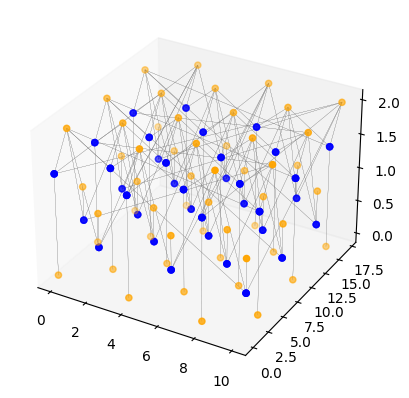

In [186]:
plt.figure(figsize=(20,15))
    
pl=nx.get_node_attributes(T,'pos')
lbls_nodes = nx.get_node_attributes(T, 'label')


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

check_nodes = np.array([pl[node] for node in sorted(T) if node >-1])
data_nodes = np.array([pl[node] for node in sorted(T) if node < 0])
ax.scatter(*check_nodes.T, color = 'orange')
ax.scatter(*data_nodes.T, color = 'blue')
ax.grid(False)

edge_xyz = np.array([(T.nodes[u]['pos'], T.nodes[v]['pos'])for u, v in T.edges()])

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray", linewidth = .1)

plt.show()


## Lets make parity check matrix:

In [194]:
H = np.zeros((len(R_nodes+G_nodes+B_nodes), len(data_nodes)))
for u,v in T.edges():
    H[u,-v+1]=1
    

IndexError: index 108 is out of bounds for axis 1 with size 108

In [191]:
for u,v in T.edges():
    print(u,v)

0 -1
0 -2
0 -3
1 -4
1 -5
1 -6
2 -7
2 -8
2 -9
3 -10
3 -11
3 -12
4 -13
4 -14
4 -15
5 -16
5 -17
5 -18
6 -19
6 -20
6 -21
7 -22
7 -23
7 -24
8 -25
8 -26
8 -27
9 -28
9 -29
9 -30
10 -31
10 -32
10 -33
11 -34
11 -35
11 -36
12 -37
12 -38
12 -39
13 -40
13 -41
13 -42
14 -43
14 -44
14 -45
15 -46
15 -47
15 -48
16 -49
16 -50
16 -51
17 -52
17 -53
17 -54
18 -55
18 -56
18 -57
19 -58
19 -59
19 -60
20 -61
20 -62
20 -63
21 -64
21 -65
21 -66
22 -67
22 -68
22 -69
23 -70
23 -71
23 -72
24 -73
24 -74
24 -75
25 -76
25 -77
25 -78
26 -79
26 -80
26 -81
27 -82
27 -83
27 -84
28 -85
28 -86
28 -87
29 -88
29 -89
29 -90
30 -91
30 -92
30 -93
31 -94
31 -95
31 -96
32 -97
32 -98
32 -99
33 -100
33 -101
33 -102
34 -103
34 -104
34 -105
35 -106
35 -107
35 -108
36 -1
36 -2
36 -3
36 -4
36 -5
36 -6
36 -46
36 -47
36 -48
36 -55
36 -56
36 -57
36 -100
36 -101
36 -102
36 -103
36 -104
36 -105
37 -4
37 -5
37 -6
37 -7
37 -8
37 -9
37 -49
37 -50
37 -51
37 -58
37 -59
37 -60
37 -103
37 -104
37 -105
37 -106
37 -107
37 -108
38 -1
38 -2
38 -3
38 -